In [ ]:
!pip install POT

In [ ]:
!git clone https://github.com/judelo/gmmot.git

fatal: destination path 'gmmot' already exists and is not an empty directory.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.linalg as spl
import scipy.stats as sps
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# Optimal Transport library https://github.com/rflamary/POT
import ot
import ot.plot

from gmmot.python.gmmot import *
from ipywidgets import interact, interactive, fixed, interact_manual

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.family"] = 'serif'

### Warm up : Distance between two Gaussian Mixture

$$W_2^2(\mu_0, \mu_1) = \|m_0 - m_1\|^2 + \text{tr}\left(\Sigma_0 + \Sigma_1 - 2 \left(\Sigma_0^{\frac{1}{2}} \Sigma_1 \Sigma_0^{\frac{1}{2}}\right)^{\frac{1}{2}}\right)$$

Above is the Wassertstein distance for two gaussian distribution of mean $m_0, m_1$ and covariance $ \Sigma_0, Σ_1$. The adapted Wasserstein distance from the article uses the formula below : \

\begin{align}
\Pi(\pi_0, \pi_1) &= \{ w \in \mathcal{M}_{K_0,K_1}(\mathbb{R}^+); \quad w \mathbf{1}_{K_1} = \pi_0; \quad w^t \mathbf{1}_{K_0} = \pi_1 \} \\
&= \{ w \in \mathcal{M}_{K_0,K_1}(\mathbb{R}^+); \quad \forall k, \sum_j w_{kj} = \pi_0^k \text{ and } \forall j, \sum_k w_{kj} = \pi_1^j \}.\\
\end{align}

$$MW_2^2(\mu_0, \mu_1) = \min_{w \in \Pi(\pi_0, \pi_1)} \sum_{k,l} w_{kl} W_2^2(\mu_0^k, \mu_1^l)$$

Below we will generate two gaussian mixture and compute the MW2 distance between the two.

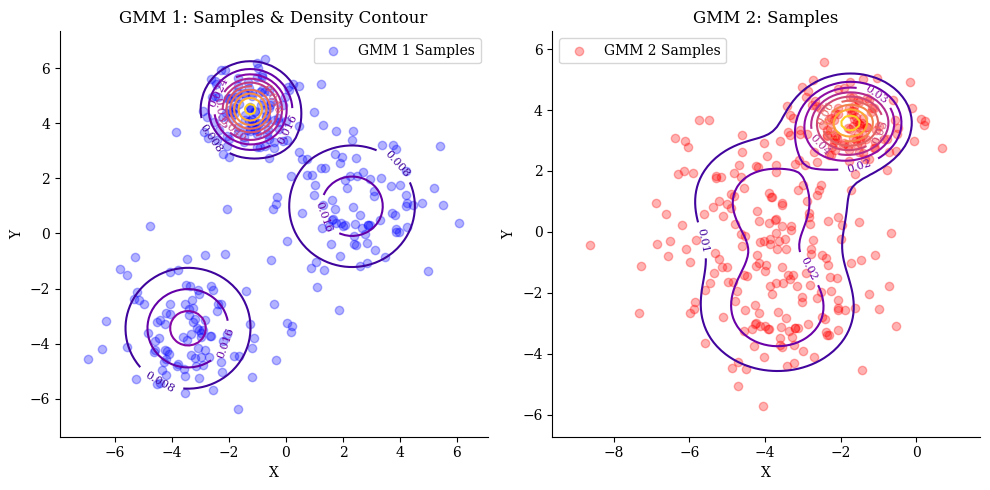

In [ ]:
def generate_random_gmm(n_gaussian = 2, seed=42, random_weights=False):
    # GMM 1: 2 components
    np.random.seed(seed)
    means_1 = np.random.uniform(-5, 5, size=(n_gaussian, 2))  # Two cluster centers in 2D
    covariances_1 = [np.eye(2) * np.random.uniform(0.5, 3) for _ in range(n_gaussian)]
    if random_weights:
      weights_1 = np.random.dirichlet([1 for i in range(n_gaussian)])
    else:
      weights_1 = np.ones(n_gaussian) / n_gaussian # Random weights
    samples_1 = sample_gmm(300, means_1, covariances_1, weights_1)
    return np.array(samples_1), np.array(means_1), np.array(covariances_1), np.array(weights_1)

def sample_gmm(n_samples, means, covariances, weights, seed=42):
    np.random.seed(seed)
    n_components = len(means)
    samples = []
    # Choose component indices based on the given weights
    component_choices = np.random.choice(n_components, size=n_samples, p=weights)
    for i in range(n_samples):
        component = component_choices[i]
        sample = np.random.multivariate_normal(means[component], covariances[component], 1)
        samples.append(sample)
    return np.vstack(samples)

def densite_theorique2d(mu, Sigma, alpha, x):
    """
    Compute the 2D GMM density at points x.

    Parameters:
      mu: array of shape (K, 2) containing the means.
      Sigma: array of shape (K, 2, 2) containing the covariance matrices.
      alpha: array of shape (1, K) containing the mixture weights.
      x: an array of points where the density is computed, shape (n_points, 2).

    Returns:
      Density values for each point in x.
    """
    K = mu.shape[0]
    alpha = alpha.reshape(1, K)
    y = 0
    for j in range(K):
        y += alpha[0, j] * sps.multivariate_normal.pdf(x, mean=mu[j, :], cov=Sigma[j, :, :])
    return y

def get_contours(samples, means, covariances, weights):
  # Use the range of samples_1 to set up the grid
  xmin, xmax = samples[:, 0].min() - 1, samples[:, 0].max() + 1
  ymin, ymax = samples[:, 1].min() - 1, samples[:, 1].max() + 1
  n = 100
  x_grid = np.linspace(xmin, xmax, n)
  y_grid = np.linspace(ymin, ymax, n)
  X, Y = np.meshgrid(x_grid, y_grid)
  XX = np.array([X.ravel(), Y.ravel()]).T

  # Compute the density for GMM 1 on the grid.
  # Convert covariances_1 to an array of shape (K, 2, 2) and reshape weights accordingly.
  Z1 = densite_theorique2d(means, np.array(covariances), weights.reshape(1, -1), XX)
  Z1 = Z1.reshape(X.shape)
  return X, Y, Z1, XX

# ---------------------------
# Generate two random GMMs
# ---------------------------

n_gaussian1 = 3
n_gaussian2 = 3
samples_1, means_1, covariances_1, weights_1 = generate_random_gmm(n_gaussian=n_gaussian1, seed=42)
samples_2, means_2, covariances_2, weights_2 = generate_random_gmm(n_gaussian=n_gaussian2, seed=43)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(samples_1[:, 0], samples_1[:, 1], alpha=0.3, c='b', label="GMM 1 Samples")
X, Y, Z1, XX = get_contours(samples_1, means_1, covariances_1, weights_1)
contours = plt.contour(X, Y, Z1, levels=10, cmap='plasma')
plt.clabel(contours, inline=True, fontsize=8)
plt.title("GMM 1: Samples & Density Contour")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

# Right subplot: GMM 2 samples only
plt.subplot(1, 2, 2)
plt.scatter(samples_2[:, 0], samples_2[:, 1], alpha=0.3, c='r', label="GMM 2 Samples")
X, Y, Z2, XX = get_contours(samples_2, means_2, covariances_2, weights_2)
print
contours = plt.contour(X, Y, Z2, levels=10, cmap='plasma')
plt.clabel(contours, inline=True, fontsize=8)
plt.title("GMM 2: Samples")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
d = 2
wstar,dist = GW2(np.ravel(weights_1),np.ravel(weights_2),means_1.reshape(n_gaussian1,d),means_2.reshape(n_gaussian2,d),covariances_1.reshape(n_gaussian1,d,d),covariances_2.reshape(n_gaussian2,d,d))
print(f"wstar = {wstar}")
print(f"dist = {dist}")

wstar = [[0.         0.         0.33333333]
 [0.33333333 0.         0.        ]
 [0.         0.33333333 0.        ]]
dist = 13.32150336443543


Now let's investigate the optimal path from the first GMM to the second GMM.

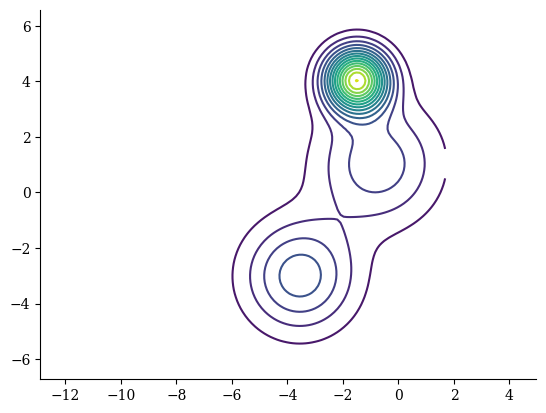

In [ ]:
def barygmmot2d(t):
    pit = wstar.reshape(n_gaussian1*n_gaussian2,1).T
    mut = np.zeros((n_gaussian1*n_gaussian2,2))
    St  = np.zeros((n_gaussian1*n_gaussian2,2,2))
    for k in range(n_gaussian1):
        for l in range(n_gaussian2):
            mut[k*n_gaussian2+l,:]  = (1-t)*means_1[k,:]+t*means_2[l,:]
            Sigma1demi = spl.sqrtm(covariances_2[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@covariances_1[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*n_gaussian2+l,:,:] = ((1-t)*np.eye(2)+t*C)@covariances_1[k,:,:]@((1-t)*np.eye(2)+t*C)

    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,15)
    plt.axis('equal')

barygmmot2d(0.5)

Let's make it interactive

In [ ]:
interact(barygmmot2d,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot2d(t)>

### The real thing : Let's train a generator network with MW2

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import ot  # pip install pot

seed = 10
torch.manual_seed(seed)

########################################
# 1. Generate a reference GMM in 2D
########################################
def random_gmm(n_components=4, d=2, seed=42):
    """
    Create random parameters for a GMM with 'n_components' in 'd' dimensions.
    Returns:
      means:     (n_components, d)
      cov_diag:  (n_components, d)  [diagonal entries only]
      weights:   (n_components,)    [mixture weights summing to 1]
    """
    torch.manual_seed(seed)
    means = np.random.randn(n_components, d)
    cov_diag = np.exp(np.random.randn(n_components, d))  # exponentiate so they're positive
    weights = np.random.rand(n_components)
    weights /= weights.sum()  # normalize to sum to 1
    return means, cov_diag, weights

means_ref_np, cov_diag_ref_np, alpha_ref_np = random_gmm(n_components=4, d=2, seed=seed)
means_ref = torch.tensor(means_ref_np, dtype=torch.float32)
cov_diag_ref = torch.tensor(cov_diag_ref_np, dtype=torch.float32)
alpha_ref = torch.tensor(alpha_ref_np, dtype=torch.float32)


class GMMNet(nn.Module):
    """
    A simple network that learns a single GMM (with diagonal covariances)
    in 2D space with 'n_components' components.
    """
    def __init__(self, n_components=4, d=2):
        super().__init__()
        # Means: shape (n_components, d)
        self.means = nn.Parameter(torch.randn(n_components, d))
        # Diagonal covariances: we store log of diagonal entries => exponentiate for positivity
        self.log_cov_diag = nn.Parameter(torch.zeros(n_components, d))
        # Mixture weights: store as logits => softmax for positivity + normalization
        self.logits = nn.Parameter(torch.zeros(n_components))

    def forward(self):
        """
        Returns:
          means_pred:    (n_components, d)
          cov_diag_pred: (n_components, d)  [diagonal of each covariance]
          alpha_pred:    (n_components,)    [mixture weights summing to 1]
        """
        alpha_pred = torch.softmax(self.logits, dim=0)
        cov_diag_pred = torch.exp(self.log_cov_diag)
        return self.means, cov_diag_pred, alpha_pred


########################################
# 3. Define the Wasserstein-type distance between two GMMs
#    using diagonal-covariance 2-Wasserstein for each pair of Gaussians
#    and discrete OT for the mixture.
########################################

def GaussianW2_diagonal_torch(m0, m1, cov0, cov1):
    """
    2-Wasserstein distance between two Gaussians in R^d with diagonal covariances.
    Formula: W2^2 = ||m0 - m1||^2 + sum_i [cov0[i] + cov1[i] - 2*sqrt(cov0[i]*cov1[i])]
    """
    # Squared distance between means
    diff = torch.sum((m0 - m1) ** 2)
    # Diagonal part
    trace_term = torch.sum(cov0 + cov1 - 2.0 * torch.sqrt(cov0 * cov1))
    return diff + trace_term

def GMM_W2_distance_torch(means0, cov0, alpha0, means1, cov1, alpha1):
    """
    Compute the GMM-GMM 2-Wasserstein distance for diagonal covariances
    using pairwise Gaussian W2 + discrete optimal transport on the mixture weights.

    This is a direct adaptation of the code snippet you provided (GaussianW2 + OT),
    but specialized to diagonal covariances in PyTorch. The OT step is done via
    'ot.emd' in NumPy, which is not differentiable w.r.t. PyTorch.
    """
    K0 = means0.shape[0]
    K1 = means1.shape[0]
    # Build cost matrix M (K0 x K1)
    M = torch.zeros(K0, K1, device=means0.device)
    for k in range(K0):
        for l in range(K1):
            M[k, l] = GaussianW2_diagonal_torch(means0[k], means1[l], cov0[k], cov1[l])
    # Use emd2 for a differentiable OT solution
    dist = ot.emd2(alpha0, alpha1, M)  # Directly use PyTorch tensors
    return dist  # dist is already a PyTorch scalar


def train_gmm_model(
    means_ref, cov_diag_ref, alpha_ref,
    n_steps=2000, lr=1e-2, seed=42,
):
    """
    Train a GMMNet so that its predicted GMM matches the reference GMM
    in the diagonal-covariance W2 sense.
    """
    torch.manual_seed(seed)
    model = GMMNet(n_components=4, d=2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    predictions = []
    losses = []

    for step in range(n_steps):
        optimizer.zero_grad()
        means_pred, cov_diag_pred, alpha_pred = model()

        loss = GMM_W2_distance_torch(
            means_pred, cov_diag_pred, alpha_pred,
            means_ref, cov_diag_ref, alpha_ref
        )
        loss.backward()
        optimizer.step()

        if step % 200 == 0:
            predictions.append((means_pred, cov_diag_pred, alpha_pred))
            losses.append(loss.item())
            print(f"Step {step:4d}, distance = {loss.item():.4f}")

    print(f"\nFinal distance after {n_steps} steps: {loss.item():.4f}")
    return model, predictions, losses

trained_model, predictions, losses = train_gmm_model(means_ref, cov_diag_ref, alpha_ref, n_steps=2000, lr=1e-2)

# Print final results
means_pred, cov_diag_pred, alpha_pred = trained_model()
print("\n=== Reference GMM Parameters ===")
print("Means:\n", means_ref)
print("Cov diag:\n", cov_diag_ref)
print("Weights:\n", alpha_ref)

print("\n=== Predicted GMM Parameters ===")
print("Means:\n", means_pred.detach())
print("Cov diag:\n", cov_diag_pred.detach())
print("Weights:\n", alpha_pred.detach())

Step    0, distance = 1.9666
Step  200, distance = 0.1075
Step  400, distance = 0.0048
Step  600, distance = 0.0052
Step  800, distance = 0.0019
Step 1000, distance = 0.0032
Step 1200, distance = 0.0034
Step 1400, distance = 0.0066
Step 1600, distance = 0.0063
Step 1800, distance = 0.0014

Final distance after 2000 steps: 0.0025

=== Reference GMM Parameters ===
Means:
 tensor([[-1.0041, -0.7678],
        [-0.0347,  0.2342],
        [ 1.5505, -0.9984],
        [ 0.9843, -0.2140]])
Cov diag:
 tensor([[ 0.9517,  1.9637],
        [ 0.3254,  1.4658],
        [ 1.1811,  1.6363],
        [ 1.3353, 11.6499]])
Weights:
 tensor([0.2833, 0.2168, 0.2708, 0.2290])

=== Predicted GMM Parameters ===
Means:
 tensor([[ 0.9846, -0.2140],
        [-0.0350,  0.2362],
        [-1.0031, -0.7673],
        [ 1.5493, -0.9970]])
Cov diag:
 tensor([[ 1.3348, 11.6376],
        [ 0.3260,  1.4671],
        [ 0.9513,  1.9642],
        [ 1.1811,  1.6402]])
Weights:
 tensor([0.2290, 0.2169, 0.2834, 0.2707])


Now let's plot what the distribution look like at every epoch

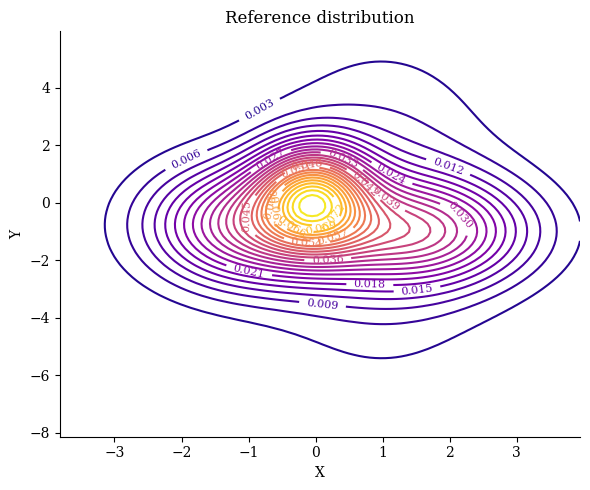

In [ ]:
def plot_torch_distribution(means_pred, cov_diag_pred, alpha_pred, ax=None, title=f"reference", levels=15):
  if ax is None:
    fig, ax = plt.subplots(figsize=(10, 5))

  samples = sample_gmm(100, means_pred, cov_diag_pred, alpha_pred, seed=43)
  X, Y, Z2, XX = get_contours(samples, means_pred, cov_diag_pred, alpha_pred)
  contours = ax.contour(X, Y, Z2, levels=levels, cmap='plasma')
  ax.clabel(contours, inline=True, fontsize=8)
  ax.set_title(title)
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

def detach_tensors(means_pred, cov_diag_pred, alpha_pred):
  means_pred = means_pred.detach().numpy()
  # cov_diag_pred should be a list of 2x2 covariance matrices
  cov_diag_pred = [np.diag(cov_diag_pred[i].detach().numpy()) for i in range(means_pred.shape[0])]
  alpha_pred = alpha_pred.detach().numpy()
  return np.array(means_pred), np.array(cov_diag_pred), np.array(alpha_pred)

def show_epochs(epoch, levels=10):
  means_pred, cov_diag_pred, alpha_pred = predictions[epoch]
  means_pred, cov_diag_pred, alpha_pred = detach_tensors(means_pred, cov_diag_pred, alpha_pred)

  means_ref_np, cov_diag_ref_np, alpha_ref_np = detach_tensors(means_ref, cov_diag_ref, alpha_ref)

  fig, ax1 = plt.subplots(figsize=(6, 5))
  # plot_torch_distribution(means_pred, cov_diag_pred, alpha_pred, ax=ax1, levels=levels, title=f"epoch: {epoch}")
  plot_torch_distribution(means_ref_np, cov_diag_ref_np, alpha_ref_np, ax=ax1, levels=levels, title=f"Reference distribution")

  # x_min = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
  # x_max = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
  # y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
  # y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

  # ax1.set_xlim(x_min, x_max)
  # ax1.set_ylim(y_min, y_max)

  plt.tight_layout()
  plt.show()

show_epochs(9, levels=30)

In [ ]:
interact(show_epochs, epoch=(0, 9, 1), levels=(1, 30, 1))

interactive(children=(IntSlider(value=4, description='epoch', max=9), IntSlider(value=10, description='levels'…

<function __main__.show_epochs(epoch, levels=10)>

And we can even compare the training of our network to an incremental approach along the GMM optimal path

In [ ]:
means_pred, cov_diag_pred, alpha_pred = predictions[0]
means_2, covariances_2, weights_2 = detach_tensors(means_pred, cov_diag_pred, alpha_pred)
means_1, covariances_1, weights_1= detach_tensors(means_ref, cov_diag_ref, alpha_ref)

samples2 = sample_gmm(100, means_2, covariances_2, weights_2, seed=43)
samples1 = sample_gmm(100, means_1, covariances_1, weights_1, seed=43)

x_min = min(min(samples1[:, 0]), min(samples2[:, 0]))
x_max = max(max(samples1[:, 0]), max(samples2[:, 0]))
y_min = min(min(samples1[:, 1]), min(samples2[:, 1]))
y_max = max(max(samples1[:, 1]), max(samples2[:, 1]))

In [ ]:
def barygmmot2d_post_training(t):
    pit = wstar.reshape(n_gaussian1*n_gaussian2,1).T
    mut = np.zeros((n_gaussian1*n_gaussian2,2))
    St  = np.zeros((n_gaussian1*n_gaussian2,2,2))
    for k in range(n_gaussian1):
        for l in range(n_gaussian2):
            mut[k*n_gaussian2+l,:]  = (1-t)*means_1[k,:]+t*means_2[l,:]
            Sigma1demi = spl.sqrtm(covariances_2[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@covariances_1[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*n_gaussian2+l,:,:] = ((1-t)*np.eye(2)+t*C)@covariances_1[k,:,:]@((1-t)*np.eye(2)+t*C)

    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,30)
    plt.axis('equal')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


interact(barygmmot2d_post_training,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot2d_post_training(t)>

## Apply GMM to the MNIST Dataset

Now, we will further our goal of training a VAE to geenrate images from the MNIST dataset. For that, we will try to see if we can extract from the MNIST dataset GMMs that can accurately represent the number. Since digits don't require a lot of strokes to draw, we can set the number of components in the GMM to the number of stroke necessary to draw the digit.

### 1) Load MNIST

In [ ]:
# Use torchvision to load MNIST; images are converted to tensors in [0,1]
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.74MB/s]


### 2) Transform images into binary white/black

In [ ]:
def get_white_pixel_coordinates(images, threshold=0.5):
    """
    Given a list of images (each assumed to be a 1x28x28 tensor), threshold each image
    and return an array of coordinates (row, col) for pixels above the threshold.
    """
    coords_list = []
    for img in images:
        # Convert image to numpy array of shape (28,28)
        arr = np.array(img.squeeze())
        # Get indices where pixel value > threshold
        coords = np.argwhere(arr > threshold)
        if coords.size > 0:
            coords_list.append(coords)
    if len(coords_list) > 0:
        return np.vstack(coords_list)
    else:
        return np.empty((0, 2))

class_coords = {}  # will store aggregated coordinates per digit
n_classes = 10

# First, group images by label
images_by_class = {i: [] for i in range(n_classes)}
for img, label in mnist_train:
    images_by_class[label].append(img)

for digit in range(n_classes):
    coords = get_white_pixel_coordinates(images_by_class[digit], threshold=0.5)
    class_coords[digit] = coords
    print(f"Digit {digit}: {coords.shape[0]} white pixel coordinates aggregated.")

Digit 0: 814737 white pixel coordinates aggregated.
Digit 1: 405905 white pixel coordinates aggregated.
Digit 2: 704417 white pixel coordinates aggregated.
Digit 3: 689473 white pixel coordinates aggregated.
Digit 4: 560501 white pixel coordinates aggregated.
Digit 5: 553828 white pixel coordinates aggregated.
Digit 6: 645600 white pixel coordinates aggregated.
Digit 7: 568207 white pixel coordinates aggregated.
Digit 8: 699885 white pixel coordinates aggregated.
Digit 9: 578878 white pixel coordinates aggregated.


### 3) Fit the GMM

In [ ]:
n_components = 10  # you can adjust the number of Gaussian components per class
class_gmms = {}   # dictionary to hold the fitted GMM for each digit

for digit in range(n_classes):
    coords = class_coords[digit]
    num_samples = min(1000, coords.shape[0])
    random_indices = np.random.choice(coords.shape[0], size=num_samples, replace=False)
    coords = coords[random_indices]
    if coords.shape[0] > 0:
        # Fit a full covariance GMM to the white pixel coordinates
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(coords)
        class_gmms[digit] = gmm
    else:
        class_gmms[digit] = None

### 4) Predict an image using the GMM

In [ ]:
def classify_image(img, class_gmms, threshold=0.5):
    """
    Given a single MNIST image (tensor shape 1x28x28), threshold it to get white pixel coordinates,
    then compute the average log-likelihood under each class's GMM.
    Returns the predicted digit and the per-class scores.
    """
    arr = np.array(img.squeeze())
    coords = np.argwhere(arr > threshold)
    if coords.shape[0] == 0:
        return None, None
    scores = {}
    for digit, gmm in class_gmms.items():
        if gmm is None:
            scores[digit] = -np.inf
        else:
            # score returns the average log-likelihood per sample
            scores[digit] = gmm.score(coords)
    # Predict the digit with the highest score
    predicted = max(scores, key=scores.get)
    return predicted, scores

# Example: Classify the first test image
test_img, test_label = mnist_test[0]
predicted, scores = classify_image(test_img, class_gmms, threshold=0.5)
print(f"True label: {test_label}, Predicted: {predicted}")
print("Scores per class:", scores)

True label: 7, Predicted: 7
Scores per class: {0: np.float64(-6.308354723915149), 1: np.float64(-7.407720696065874), 2: np.float64(-6.279176522176664), 3: np.float64(-5.989935266068285), 4: np.float64(-5.998123343042209), 5: np.float64(-6.082493059117175), 6: np.float64(-6.969619452318052), 7: np.float64(-5.214478027237648), 8: np.float64(-5.939015880959813), 9: np.float64(-5.570959377198501)}


### 5) Visualize the class

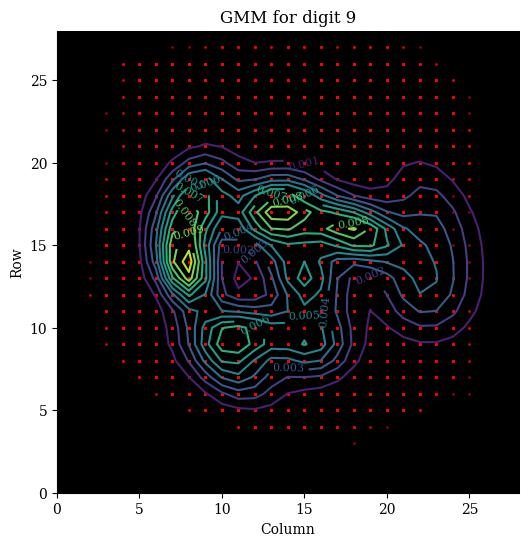

In [ ]:
def visualize_class_gmm(digit, class_gmms, class_coords, grid_size=28, levels=10):
    """
    Plot the fitted GMM density contours for the specified digit.
    The contours are overlaid on the aggregated white pixel coordinates.
    """
    gmm = class_gmms[digit]
    coords = class_coords[digit]
    if gmm is None or coords.shape[0] == 0:
        print(f"No data for digit {digit}")
        return

    # Create a grid over the image domain
    x = np.linspace(0, grid_size - 1, grid_size)
    y = np.linspace(0, grid_size - 1, grid_size)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])

    # Compute the density (note: score_samples returns log-density)
    log_density = gmm.score_samples(grid_points)
    density = np.exp(log_density)
    Z = density.reshape(X.shape)

    plt.figure(figsize=(6,6))
    # Optionally, show an empty background or an average image
    plt.imshow(np.zeros((grid_size, grid_size)), cmap='gray', origin='upper', extent=(0,grid_size,grid_size,0))
    # Plot contours of the GMM density
    contours = plt.contour(X, Y, Z, levels=levels, cmap='viridis')
    plt.clabel(contours, inline=True, fontsize=8)
    # Overlay the white pixel coordinates
    plt.scatter(coords[:,1], coords[:,0], s=1, c='red', alpha=0.5)
    plt.title(f'GMM for digit {digit}')
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.gca().invert_yaxis()  # so that row 0 is at the top
    plt.show()

# Visualize the GMM for digit 5 as an example
visualize_class_gmm(9, class_gmms, class_coords)


In [ ]:
good_prediction = 0
n_samples = 10000

for i in range(n_samples):
    test_img, test_label = mnist_test[i]
    predicted, scores = classify_image(test_img, class_gmms, threshold=0.5)
    if predicted == test_label:
        good_prediction += 1

print(f"accuracy : {good_prediction / n_samples *100} %")

accuracy : 80.7 %


Interestingly enough, our GMM classifier reaches an accuracy of 80%, which is really not bad. This must mean we could train a generator to display decent picture.

# Train a generator for MNIST !

Epoch 0 Average Loss: 183.7067
Epoch 1 Average Loss: 161.7776
Epoch 2 Average Loss: 157.0823
Epoch 3 Average Loss: 154.6596
Epoch 4 Average Loss: 153.0302
Epoch 5 Average Loss: 151.6617
Epoch 6 Average Loss: 150.6132
Epoch 7 Average Loss: 149.7008
Epoch 8 Average Loss: 148.8026
Epoch 9 Average Loss: 148.1231


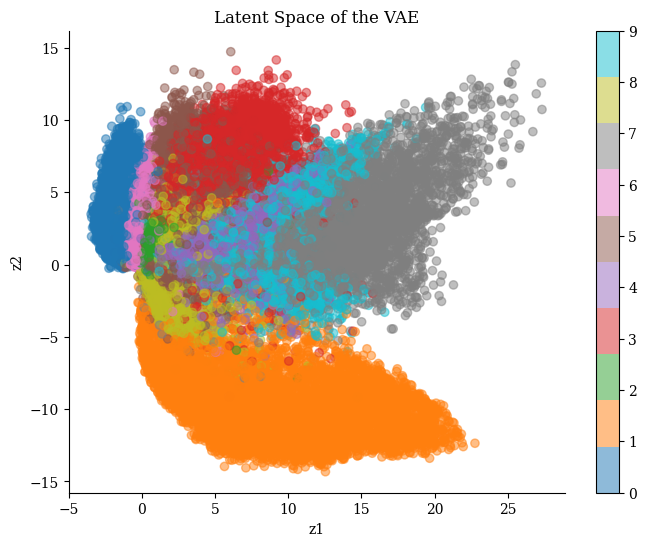

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ot  # pip install pot
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

########################################
# 1. Define a VAE (with 2D latent space for visualization)
########################################

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder network
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder network
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc_dec1(z))
        return torch.sigmoid(self.fc_dec2(h))  # for MNIST (values in [0,1])

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

########################################
# 2. Differentiable GMM fitting from latent codes (soft clustering)
########################################

def differentiable_gmm(z, n_components=4, tau=1.0):
    """
    Given latent codes z (batch_size x latent_dim), we compute a soft-assignment
    to n_components clusters, then compute cluster means, diagonal variances, and mixture weights.
    This procedure is differentiable.
    """
    batch_size, latent_dim = z.shape
    # Initialize cluster centers: pick n_components random samples from z
    indices = torch.randperm(batch_size)[:n_components]
    centers = z[indices]  # (n_components, latent_dim)

    # Compute squared Euclidean distances: (batch_size, n_components)
    dists = torch.cdist(z, centers, p=2)**2
    # Soft assignments: higher probability for closer centers.
    responsibilities = torch.softmax(-dists / tau, dim=1)

    # Compute new (soft) cluster centers as weighted average of z.
    weights = responsibilities.sum(dim=0)  # (n_components,)
    centers_new = torch.matmul(responsibilities.t(), z) / (weights.unsqueeze(1) + 1e-8)

    # Compute diagonal covariance for each cluster: variance along each dimension.
    covariances = []
    for k in range(n_components):
        diff = z - centers_new[k]  # (batch_size, latent_dim)
        sq_diff = diff**2
        cov_k = (responsibilities[:, k].unsqueeze(1) * sq_diff).sum(dim=0) / (weights[k] + 1e-8)
        covariances.append(cov_k)
    covariances = torch.stack(covariances, dim=0)  # (n_components, latent_dim)

    # The mixture weights for the GMM are the average responsibilities.
    gmm_weights = weights / batch_size
    return centers_new, covariances, gmm_weights

########################################
# 3. MW2 (Gaussian 2-Wasserstein) loss between two GMMs (diagonal covariances)
########################################

def gaussian_w2_diagonal(m0, m1, cov0, cov1):
    """
    Compute the 2-Wasserstein distance between two Gaussians in latent space with diagonal covariances.
    Formula: ||m0 - m1||^2 + sum_i (cov0[i] + cov1[i] - 2 * sqrt(cov0[i] * cov1[i]))
    """
    diff = torch.sum((m0 - m1) ** 2)
    trace_term = torch.sum(cov0 + cov1 - 2 * torch.sqrt(cov0 * cov1 + 1e-8))
    return diff + trace_term

def gmm_w2_distance(means1, covs1, weights1, means2, covs2, weights2):
    """
    Compute a discrete OT-based distance between two GMMs (with diagonal covariances)
    by matching each component with cost given by the Gaussian W2 distance.
    """
    K = means1.shape[0]
    L = means2.shape[0]
    cost_matrix = torch.zeros(K, L, device=means1.device)
    for k in range(K):
        for l in range(L):
            cost_matrix[k, l] = gaussian_w2_diagonal(means1[k], means2[l], covs1[k], covs2[l])
    # Convert cost and weights to NumPy for OT solver (this part is non-differentiable)
    cost_np = cost_matrix.detach().cpu().numpy()
    w1_np = weights1.detach().cpu().numpy()
    w2_np = weights2.detach().cpu().numpy()
    # Compute OT cost (squared MW2 distance)
    dist = ot.emd2(w1_np, w2_np, cost_np)
    return torch.tensor(dist, dtype=means1.dtype, device=means1.device)

########################################
# 4. Training procedure for the VAE using MW2 loss in latent space
########################################

def train_vae_mw2(vae, dataloader, optimizer, prior_gmm, n_epochs=10, device='cpu', beta=1.0):
    """
    For each mini-batch:
      - Run the VAE forward pass and get latent codes z.
      - Fit a GMM to z via differentiable soft clustering.
      - Compute MW2 distance between this fitted GMM and a fixed prior GMM (in latent space).
      - Use reconstruction loss + beta * MW2 loss as overall loss.
    prior_gmm is a tuple (prior_means, prior_covs, prior_weights).
    """
    vae.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device).view(data.size(0), -1)
            optimizer.zero_grad()
            x_recon, mu, logvar, z = vae(data)
            # Reconstruction loss (binary cross-entropy)
            recon_loss = nn.functional.binary_cross_entropy(x_recon, data, reduction='sum')
            # Fit a GMM to the latent codes z using our differentiable procedure.
            means_fit, covs_fit, weights_fit = differentiable_gmm(z, n_components=prior_gmm[0].shape[0])
            # Compute the MW2 distance between the fitted GMM and the fixed prior GMM.
            mw2_loss = gmm_w2_distance(means_fit, covs_fit, weights_fit,
                                       prior_gmm[0], prior_gmm[1], prior_gmm[2])
            loss = recon_loss + beta * mw2_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader.dataset)
        print(f"Epoch {epoch} Average Loss: {avg_loss:.4f}")
    return vae

########################################
# 5. Set up dataset, dataloader, and a fixed prior GMM in latent space
########################################ou

# Use MNIST from torchvision
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2

# Initialize the VAE.
vae = VAE(input_dim=784, hidden_dim=400, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Define a fixed prior GMM in latent space (e.g. 4 components arranged on a circle)
n_components_prior = 4
angles = np.linspace(0, 2 * np.pi, n_components_prior, endpoint=False)
prior_means_np = np.stack([np.cos(angles), np.sin(angles)], axis=1)
prior_means = torch.tensor(prior_means_np, dtype=torch.float32, device=device)
prior_covs = torch.ones(n_components_prior, latent_dim, device=device) * 0.5  # diagonal variances
prior_weights = torch.ones(n_components_prior, device=device) / n_components_prior
prior_gmm = (prior_means, prior_covs, prior_weights)

########################################
# 6. Train the VAE with the MW2 loss
########################################

n_epochs = 10
vae = train_vae_mw2(vae, train_loader, optimizer, prior_gmm, n_epochs=n_epochs, device=device, beta=1.0)

########################################
# 7. (Optional) Visualize the latent space of the trained VAE
########################################

def visualize_latent_space(vae, dataloader, device='cpu'):
    vae.eval()
    zs = []
    labels = []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device).view(data.size(0), -1)
            _, _, _, z = vae(data)
            zs.append(z.cpu().numpy())
            labels.append(target.cpu().numpy())
    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)
    plt.figure(figsize=(8, 6))
    plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.title("Latent Space of the VAE")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.colorbar()
    plt.show()

visualize_latent_space(vae, train_loader, device=device)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_generated_images(vae, prior_gmm, n_samples=16, device='cpu'):
    """
    Generate images by sampling latent vectors from a prior GMM and decoding them
    using the trained VAE. The prior_gmm is a tuple (prior_means, prior_covs, prior_weights)
    where:
      - prior_means: tensor of shape (n_components, latent_dim)
      - prior_covs:  tensor of shape (n_components, latent_dim) representing diagonal variances
      - prior_weights: tensor of shape (n_components,) summing to 1
    The function plots the generated images in a grid.
    """
    prior_means, prior_covs, prior_weights = prior_gmm
    latent_dim = prior_means.shape[1]
    zs = []

    # Convert prior_weights to numpy for sampling
    weights_np = prior_weights.detach().cpu().numpy()
    n_components = prior_means.shape[0]

    for i in range(n_samples):
        # Randomly choose a component index according to the prior weights
        comp = np.random.choice(n_components, p=weights_np)
        mean = prior_means[comp]
        cov = prior_covs[comp]
        std = torch.sqrt(cov)
        # Sample a latent vector: z = mean + std * noise
        z = mean + std * torch.randn(latent_dim, device=device)
        zs.append(z)
    zs = torch.stack(zs, dim=0)

    # Decode the latent vectors to generate images
    with torch.no_grad():
        generated = vae.decode(zs.to(device))
    # For MNIST, reshape images from [n_samples, 784] to [n_samples, 28, 28]
    generated = generated.view(-1, 28, 28).cpu().numpy()

    # Plot the images in a grid
    n_rows = int(np.sqrt(n_samples))
    n_cols = int(np.ceil(n_samples / n_rows))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < n_samples:
            ax.imshow(generated[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle("Generated Images from VAE")
    plt.show()
